In [2]:
#Testing of trained AM-SegNet:

# Construct model structure
# Load trained model weights
# Load images for model testing
# Peform semantic segmentation 

In [3]:
#import libraries for model development
from keras import models, layers
from keras import backend as K
import numpy as np
import glob
import cv2
import os

In [4]:
#Definition of lightweight block (lw_conv_block)

def lw_conv_block(inputs, filter_size, filter_num, dropout, batch_norm=True):

    conv = layers.Conv2D(filter_num, (1, 1), padding='same')(inputs)
    conv = layers.Activation('relu')(conv)

    #left
    squeeze_conv = layers.Conv2D(filter_num,(1, 1), padding='same')(conv)

    # Batch normalization operation
    if batch_norm is True:
        squeeze_conv = layers.BatchNormalization(axis=3)(squeeze_conv)

    squeeze_conv = layers.Activation("relu")(squeeze_conv)

    #middle
    channel_conv = layers.DepthwiseConv2D(kernel_size=(filter_size, filter_size), strides=(1, 1), padding='same', depth_multiplier=2)(conv)
    point_conv = layers.Conv2D(2*filter_num, (1, 1), padding='same')(channel_conv)
    
    # Batch normalization operation
    if batch_norm is True:
        separa_conv = layers.BatchNormalization(axis=3)(point_conv)
    else:
        separa_conv = point_conv
        
    separa_conv = layers.Activation("relu")(separa_conv)

    #right
    expand_conv = layers.Conv2D(filter_num,(filter_size, filter_size), padding='same')(conv)
    
    # Batch normalization operation
    if batch_norm is True:
        expand_conv = layers.BatchNormalization(axis=3)(expand_conv)

    expand_conv = layers.Activation("relu")(expand_conv)

    #concatenate
    lw_conv = layers.concatenate([squeeze_conv, separa_conv, expand_conv], axis=3)
    
    # Dropout operation
    if dropout > 0:
        lw_conv = layers.Dropout(dropout)(lw_conv)

    return lw_conv

In [5]:
#Definition of convolution block

def stand_conv_block(inputs, filter_size, filter_num, dropout, batch_norm=True):

    conv = layers.Conv2D(filter_num, (filter_size, filter_size), padding='same')(inputs)
    
    # Batch normalization operation
    if batch_norm is True:

        conv = layers.BatchNormalization(axis=3)(conv)

    conv_output = layers.Activation('relu')(conv)

    # Dropout operation
    if dropout > 0:
        
        conv_output = layers.Dropout(dropout)(conv_output)

    return conv_output

In [6]:
#Definition of attention block

def attention_block(x, gating, size):

# Convert gating single using (1,1) convolutions
    phi_g = layers.Conv2D(size, (1, 1), padding='same')(gating) 

# Convert x single to the same shape as the gating signal
    theta_x = layers.Conv2D(size, (1, 1), padding='same')(x) 

# Adding phi_g, theta_x together, activated by relu
    concat_xg = layers.add([phi_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)

# Conduct ψ operation on act_xg, then activated by sigmoid
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)

# Conduct multiply operation on [upsample_psi, x]
    result = layers.multiply([sigmoid_xg, x])
    result_bn = layers.BatchNormalization()(result)
    
    return result_bn

In [7]:
#Definition of repeat_elem for element repeating

def repeat_elem(tensor, rep):
     
     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

In [8]:
# Definition of AM-SegNet with lightweight block and attention mechanism

def AM_SegNet(input_shape, num_classes, dropout, batch_norm):

    # parameters of network congfiguration

    filter_num = 12 # number of filters
    filter_size = 3 # size of filters
    up_samp_size = 2 # size of upsampling filters

    inputs = layers.Input(input_shape)

    # Downsampling

    # Downsampling step 1
    conv_1 = lw_conv_block(inputs, filter_size, 1*filter_num, dropout, batch_norm)
    pool_1 = layers.MaxPooling2D(pool_size=(2,2))(conv_1)

    # Downsampling step 2
    conv_2 = lw_conv_block(pool_1, filter_size, 2*filter_num, dropout, batch_norm)
    pool_2 = layers.MaxPooling2D(pool_size=(2,2))(conv_2)

    # Downsampling step 3
    conv_3 = lw_conv_block(pool_2, filter_size, 4*filter_num, dropout, batch_norm)
    pool_3 = layers.MaxPooling2D(pool_size=(2,2))(conv_3)

    # Downsampling step 5
    conv_4 = lw_conv_block(pool_3, filter_size, 8*filter_num, dropout, batch_norm)
    pool_4 = layers.MaxPooling2D(pool_size=(2,2))(conv_4)

    # Standard convolution only
    conv_5_1 = stand_conv_block(pool_4, filter_size, 64*filter_num, dropout, batch_norm)
    conv_5_2 = stand_conv_block(conv_5_1, filter_size, 64*filter_num, dropout, batch_norm)
    conv_5_3 = stand_conv_block(conv_5_2, filter_size, 64*filter_num, dropout, batch_norm)

    #Calculate Attention
    conv_att = attention_block(conv_5_1, conv_5_3, 64*filter_num)
    conv_5 = layers.add([conv_5_3, conv_att])

    # Upsampling

    # Upsampling step 1

    up_1 = layers.UpSampling2D(size=(up_samp_size, up_samp_size), data_format="channels_last")(conv_5)
    up_1 = layers.concatenate([up_1, conv_4], axis=3)
    up_conv_1 = stand_conv_block(up_1, filter_size, 16*filter_num, dropout, batch_norm)
   
    # Upsampling step 2
    up_conv_1 = layers.Conv2D(16*filter_num, (filter_size, filter_size), padding='same')(up_conv_1)
    up_2 = layers.UpSampling2D(size=(up_samp_size, up_samp_size), data_format="channels_last")(up_conv_1)
    up_2 = layers.concatenate([up_2, conv_3], axis=3)
    up_conv_2 = stand_conv_block(up_2, filter_size, 8*filter_num, dropout, batch_norm)

    # Upsampling step 3
    up_conv_2 = layers.Conv2D(8*filter_num, (filter_size, filter_size), padding='same')(up_conv_2)
    up_3 = layers.UpSampling2D(size=(up_samp_size, up_samp_size), data_format="channels_last")(up_conv_2)
    up_3 = layers.concatenate([up_3, conv_2], axis=3)
    up_conv_3 = stand_conv_block(up_3, filter_size, 4*filter_num, dropout, batch_norm)

    # Upsampling step 4
    up_conv_3 = layers.Conv2D(4*filter_num, (filter_size, filter_size), padding='same')(up_conv_3)
    up_4 = layers.UpSampling2D(size=(up_samp_size, up_samp_size), data_format="channels_last")(up_conv_3)
    up_4 = layers.concatenate([up_4, conv_1], axis=3)
    up_conv_4 = stand_conv_block(up_4, filter_size, 2*filter_num, dropout, batch_norm)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(num_classes, kernel_size=(1,1))(up_conv_4)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('softmax')(conv_final)  #Change to softmax for multichannel
    
    # Model 
    model = models.Model(inputs, conv_final, name="AM-SegNet")
    
    # print model summary for details
    print(model.summary())

    return model

In [9]:
#Size of images and input shape
input_size_x= 256 
input_size_y= 512
input_size = (input_size_x,input_size_y,1)

In [10]:
#Number of pixel labels: Keyhole, pore, substract, background and powder
class_num=5

#Setting dropout rate
dropout=0.0

In [11]:
#create the AM-SegNet model
model = AM_SegNet(input_size, class_num, dropout, batch_norm=True)

Model: "AM-SegNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 512,  │         24 │ input_layer[0][0] │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 512,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 256, 512,  │        240 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 512,  │        156 │ activation[0][0]  │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 512,  │        600 │ depthwise_conv2d… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 512,  │      1,308 │ activation[0][0]  │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 512,  │         48 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 512,  │         96 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 512,  │         48 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256, 512,  │          0 │ activation_1[0][… │
│ (Concatenate)       │ 48)               │            │ activation_2[0][… │
│                     │                   │            │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 256,  │          0 │ concatenate[0][0] │
│ (MaxPooling2D)      │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 256,  │      1,176 │ max_pooling2d[0]… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 17,534,378 (66.89 MB)

 Trainable params: 17,526,064 (66.86 MB)

 Non-trainable params: 8,314 (32.48 KB)

None


In [12]:
#Load X-ray images for model testing
# test_images = []

# for directory_path in glob.glob(r"C:\Users\joser\AMSegNet\Test images"):
#     for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
#         img = cv2.imread(img_path, 0)       
#         test_images.append(img)
       
# #Convert image list to np.array       
# test_images = np.array(test_images)

In [35]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.colors import ListedColormap

# test_image_path = r"C:\Users\joser\AMSegNet\Test images"
test_image_path = r"C:\Users\joser\Downloads\cf_jose"
subfolders = [os.path.join(root, d) for root, dirs, _ in os.walk(test_image_path) for d in dirs]
# subfolders = [r"C:\Users\joser\Downloads\cf_jose\DESY2022-Q4_HV536_7075_d20_003_TD8001_v100_p1000_w0_Sw"]
print(subfolders)

model.load_weights(r'C:\Users\joser\Downloads\Model weight_AM_SegNet.hdf5')

# output_folder = "Tested images"
output_folder = r"C:\Users\joser\OneDrive\Desktop\Projektarbeit\Segmented_Images"
os.makedirs(output_folder, exist_ok=True)
colors = ['#541352FF', '#d62728', '#2f9aa0FF', '#10a53dFF', '#ffcf20FF']
custom_cmap = ListedColormap(colors)
non_segemented = []

for j in subfolders:
    test_images = []
    print(j)
    for img_path in glob.glob(os.path.join(j, "*.tif")):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            non_segemented.append(img_path)
            continue
        resized_image = cv2.resize(img,(512,256))   
        test_images.append(resized_image)
    test_images = np.array(test_images)

    # os.makedirs(os.path.join(os.getcwd(),output_folder,os.path.basename(j)),exist_ok=True)
    output_subfolder = os.path.join(output_folder, os.path.basename(j))
    os.makedirs(output_subfolder, exist_ok=True)

    img_input = len(glob.glob(os.path.join(j, "*.tif")))
    img_output = len(glob.glob(os.path.join(os.path.join(os.getcwd(),output_folder,os.path.basename(j)), "*.png")))

    if test_images.size == 0 or img_input == img_output:
        continue
    max_size = 500
    y_pred_argmax = []
    if len(test_images) > max_size:
        for i in range(0,len(test_images),max_size):
            chunk = test_images[i:i + max_size]
            y_pred = model.predict(chunk)
            y_pred_argmax_chunk = np.argmax(y_pred,axis=3)
            y_pred_argmax.append(y_pred_argmax_chunk)
        y_pred_argmax = np.concatenate(y_pred_argmax, axis=0)
    else:
        y_pred=model.predict(test_images)
        y_pred_argmax=np.argmax(y_pred, axis=3)

    segmented_paths = [x for x in glob.glob(os.path.join(j, "*.tif")) if x not in non_segemented]
    for i, img_path in enumerate(segmented_paths):
        input_filename = os.path.basename(img_path)
        print(input_filename)
        output_filename = os.path.splitext(input_filename)[0] + '.png'
        output_path = os.path.join(output_folder,os.path.basename(j),output_filename)
        plt.imsave(output_path, y_pred_argmax[i], cmap=custom_cmap, format='png')
        print(f"Saved: {output_path}")      

['C:\\Users\\joser\\Downloads\\cf_jose\\DESY2022-Q4_HV513_14301_d20_012_TD8001_v400_p4000_w0_Sw', 'C:\\Users\\joser\\Downloads\\cf_jose\\DESY2022-Q4_HV514_14301_d20_002_TD8001_v20_p500_w0_Sw', 'C:\\Users\\joser\\Downloads\\cf_jose\\DESY2022-Q4_HV515_14301_d20_002_TD8001_v50_p500_w0_Sw', 'C:\\Users\\joser\\Downloads\\cf_jose\\DESY2022-Q4_HV516_14301_d20_002_TD8001_v100_p500_w0_Sw', 'C:\\Users\\joser\\Downloads\\cf_jose\\DESY2022-Q4_HV517_14301_d20_002_TD8001_v150_p500_w0_Sw', 'C:\\Users\\joser\\Downloads\\cf_jose\\DESY2022-Q4_HV518_14301_d20_002_TD8001_v30_p500_w0_Sw', 'C:\\Users\\joser\\Downloads\\cf_jose\\DESY2022-Q4_HV519_14301_d20_002_TD8001_v20_p1000_w0_Sw', 'C:\\Users\\joser\\Downloads\\cf_jose\\DESY2022-Q4_HV520_14301_d20_002_TD8001_v50_p1000_w0_Sw', 'C:\\Users\\joser\\Downloads\\cf_jose\\DESY2022-Q4_HV521_14301_d20_002_TD8001_v100_p1000_w0_Sw', 'C:\\Users\\joser\\Downloads\\cf_jose\\DESY2022-Q4_HV522_14301_d20_002_TD8001_v150_p1000_w0_Sw', 'C:\\Users\\joser\\Downloads\\cf_jose\\

In [31]:
path = r"C:\Users\joser\Downloads\cf_jose\DESY2022-Q4_HV536_7075_d20_003_TD8001_v100_p1000_w0_Sw\DESY2022-Q4_HV536_7075_d20_003_TD8001_v100_p1000_w0_Sw_357.tif"
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
print(img)


[[53 53 53 ... 53 53 53]
 [53 53 53 ... 53 53 53]
 [53 53 53 ... 53 53 53]
 ...
 [53 53 53 ... 53 53 53]
 [53 53 53 ... 53 53 53]
 [53 53 53 ... 53 53 53]]


In [14]:
# #Load pre-trained model weights
# model.load_weights(r'C:\Users\joser\Downloads\Model weight_AM_SegNet.hdf5')

In [15]:
# #Perform semantic segmentation analysis
# y_pred=model.predict(test_images)
# y_pred_argmax=np.argmax(y_pred, axis=3)

(-0.5, 511.5, 255.5, -0.5)

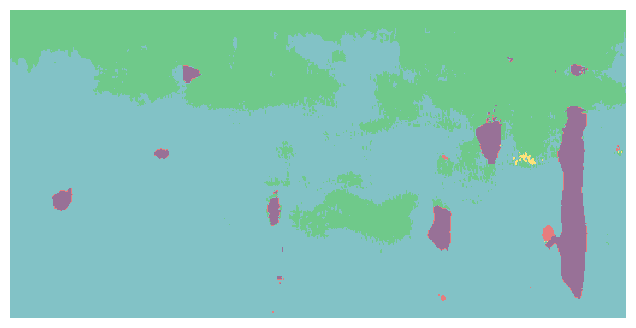

In [16]:
#Plot segmention results using customised colormap
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.colors import ListedColormap

# Customised color map
colors = ['#541352FF', '#d62728', '#2f9aa0FF', '#10a53dFF', '#ffcf20FF']
custom_cmap = ListedColormap(colors)

#Plot the segmention results, e.g. the first one in the image list
figure(figsize=(8, 4))
plt.imshow(y_pred_argmax[0], cmap= custom_cmap, alpha=0.60)
plt.axis('off')

In [17]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.colors import ListedColormap

output_folder = "Tested images"
os.makedirs(output_folder, exist_ok=True)
colors = ['#541352FF', '#d62728', '#2f9aa0FF', '#10a53dFF', '#ffcf20FF']
custom_cmap = ListedColormap(colors)

for i, img_path in enumerate(glob.glob(os.path.join(directory_path, "*.tif"))):
    input_filename = os.path.basename(img_path)
    output_filename = os.path.splitext(input_filename)[0] + '.png'
    output_path = os.path.join(output_folder,'HV156',output_filename)

    plt.imsave(output_path, y_pred_argmax[i], cmap=custom_cmap, format='png')
    print(f"Saved: {output_path}")
IoU_flag = False

NameError: name 'directory_path' is not defined

In [57]:
if IoU_flag:
    # Define the RGB colors in the ground truth
    ground_truth_colors = {
        (1, 0, 0): 1,         # Background (Label ID 1)
        (0, 1, 0): 2,         # Substrate (Label ID 2)
        (1, 0, 1): 3,         # Keyhole (Label ID 3)
        (1, 1, 0.0667): 4,    # Pore (Label ID 4)
        (0, 1, 1): 5,         # Molten_pool (Label ID 5)
    }

    # Convert ground truth RGB images to class labels
    def convert_ground_truth_to_labels(ground_truth_image):
        height, width, _ = ground_truth_image.shape
        ground_truth_labels = np.zeros((height, width), dtype=int)

        for color, label in ground_truth_colors.items():
            ground_truth_labels[np.all(ground_truth_image == color, axis=-1)] = label

        # Ignore 'Molten_pool' by mapping it to Background
        ground_truth_labels[ground_truth_labels == 5] = 2

        return ground_truth_labels

    # Example ground truth image
    ground_truth_image = cv2.imread(r"C:\Users\joser\OneDrive\Desktop\Projektarbeit\Labeling\Labeling_HV156\GroundTruthProject\PixelLabelData\Label_1_DESY2022-Q4_HV156_7075_d20_002_TD8001_v50_p600_w0_Sw_444.png")
    ground_truth_resized = cv2.resize(ground_truth_image, (y_pred_argmax[0].shape[1], y_pred_argmax[0].shape[0]))
    ground_truth_resized[ground_truth_resized == 5] = 2
    ground_truth_labels = ground_truth_resized[:, :, 0]
    # ground_truth_labels = convert_ground_truth_to_labels(ground_truth_resized)
    np.set_printoptions(threshold=np.inf)

In [ ]:
if IoU_flag:
    def apply_class_colors(prediction, class_to_color):
            colored_prediction = np.zeros((prediction.shape[0], prediction.shape[1], 3), dtype=np.uint8)
            for class_id, color in class_to_color.items():
                colored_prediction[prediction == class_id] = color
            return colored_prediction

        # Map model class IDs to their respective RGB colors
    class_to_color = {
        1: (16, 165, 61),   # Background
        2: (47, 154, 160),  # Substrate
        3: (84, 19, 82),    # Keyhole
        4: (214, 39, 40),   # Pore
        # 1: (1,0,0),   # Background
        # 2: (0,1,0),  # Substrate
        # 3: (1,0,1),    # Keyhole
        # 4: (1, 1, 0.0667),   # Pore
    }

        # Apply color mapping to predicted output
    colored_prediction = apply_class_colors(y_pred_argmax[0], class_to_color)

    # Save or display the colored image
    cv2.imwrite('segmented_image.png', colored_prediction) 

In [ ]:
from sklearn.metrics import jaccard_score
if IoU_flag:
    def calculate_iou(prediction, ground_truth, num_classes=5):
        iou = []
        for i in range(1, num_classes): 
            prediction_flat = (prediction == i).astype(int).flatten()
            ground_truth_flat = (ground_truth == i).astype(int).flatten()
            iou.append(jaccard_score(ground_truth_flat, prediction_flat))
        return iou

    # Compute IoU for each class (ignore Molten_pool, so we only consider classes 1-4)
    iou_scores = calculate_iou(y_pred_argmax[0], ground_truth_labels, num_classes=5)
    print(f"IoU scores for each class (ignoring Molten_pool): {iou_scores}")